In [1]:
import numpy as np
import pandas as pd
import urllib.request as url
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
file = "https://neos-guide.org/sites/default/files/mizon_data.txt"
raw = [line.decode('utf-8').split() for line in url.urlopen(file)]

In [3]:
data = pd.DataFrame(raw[1:], columns=['week', 'output', 'capital', 'labor'])
data.loc[71, 'labor'] = 102.240
data = data.astype(float).astype(int)
data.shape

(72, 4)

---
#### Regress to find Cobb-Douglas parameters

$$ \text{Cobb-Douglas: } Q = A K^{\alpha} L^{\beta} $$

$$ \ln(Q) = \ln(A K^\alpha L^\beta) $$
$$ \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; = \ln(A) + \alpha \ln(K) + \beta \ln(L) $$

$$ \text{CD parameters: } \theta = [A, \alpha, \beta] $$

$$ \text{Linear regression: } y = X \theta $$
$$ \theta = (X^T X)^{-1} X^T y $$

In [4]:
ln_y = np.log(data['output'].values)
ln_X = np.c_[
    np.ones((data.shape[0],1)), 
    np.log(data[['capital', 'labor']].values),
    ]

In [5]:
betas = np.linalg.inv(ln_X.T.dot(ln_X)).dot(ln_X.T).dot(ln_y)

In [6]:
e = (1-(betas[1]+betas[2]))/2

beta_0 = np.exp(betas[0])
beta_1 = betas[1]+e
beta_2 = betas[2]+e

In [7]:
beta_0, beta_1, beta_2

(1.7785664111445918, 0.23837847401070522, 0.7616215259892948)

---
#### Formulate Cobb-Douglas with regressed parameters

$$ \ln(f(K,L)) = \ln(0.576) + 0.238 \ln(K) + 0.762 \ln(L) $$

$$ f(K,L) = 1.779 K^{0.238} L^{0.7a2} $$

In [8]:
output = lambda k,l: beta_0 * k**beta_1 * l**beta_2

In [9]:
y_hat = np.array([output(*x) for x in data[['capital', 'labor']].values])

In [10]:
data['y_hat'] = y_hat
data.head()

,week,output,capital,labor,y_hat
0,1,378,250,270,471.483335
1,2,192,101,93,168.692644
2,3,27,63,7,21.020304
3,4,31,129,17,49.014618
4,5,417,397,201,420.464658


#### Plot Cobb-Douglas

In [11]:
K, L = np.meshgrid(np.arange(4000),np.arange(4000))
Q = output(K, L)

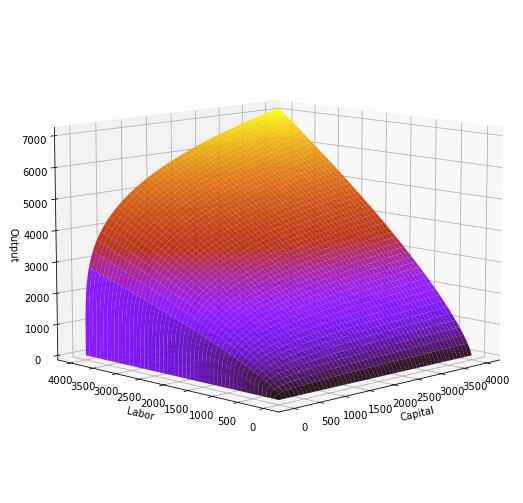

In [12]:
plt.figure(figsize=(9,9))

ax = plt.axes(projection='3d')
ax.plot_surface(K, L, Q, cmap='gnuplot', alpha=0.9)

#ax.plot_surface(K, L, Q, cmap='coolwarm', alpha=0.7)
#for i in np.arange(data[data<1000].shape[0]):
#    ax.scatter(*data[data<1000].loc[i, ['capital', labor', 'output']].values, s=10, c='k')

ax.view_init(10,225)
ax.set_xlabel('Capital')
ax.set_ylabel('Labor')
ax.set_zlabel('Output')

plt.show()

---
#### Define budget constraint

$$ \text{Budget constraint: } B = rK + wL $$

$$ 5000 = 1.5K + 1.92L $$

In [13]:
bdgt, rent, wage = 5000, 1.5, 1.92
labor_constraint = lambda k: (bdgt - rent*k) / wage
capital_constraint = lambda l: (bdgt - wage*l) / rent

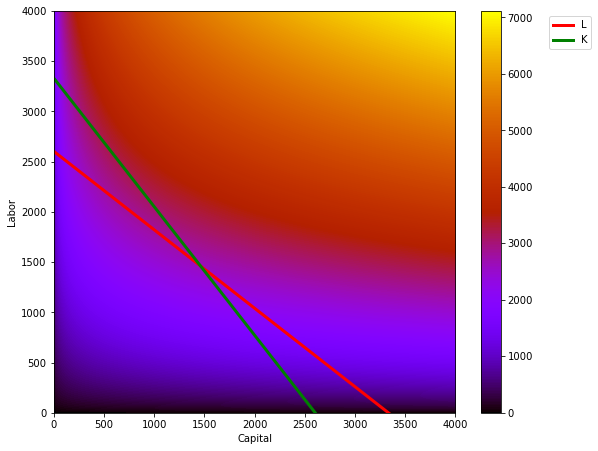

In [14]:
plt.figure(figsize=(9,9))

plt.imshow(Q, cmap='gnuplot')
plt.plot(labor_constraint(np.linspace(0,4000,4000)), 'r-', linewidth=3, label='L')
plt.plot(capital_constraint(np.linspace(0,4000,4000)), 'g-', linewidth=3, label='K')

plt.xlim([0,4000])
plt.ylim([0,4000])
plt.xlabel('Capital')
plt.ylabel('Labor')
plt.legend(loc='upper right', bbox_to_anchor=(1.35,1.0))
plt.colorbar(shrink=0.821)

---
#### Define objective function for constrained optimization using Lagrangian


$$ \mathcal{L} = A K^\alpha L^\beta + \lambda(B - rK - wL) $$

$$ \mathcal{L} = 1.779 K^{0.238} L^{0.762} + \lambda(5000 - 1.5K - 1.92L) $$

##### Solve using Newton's Method:

In [15]:
def bordered_hessian(a, k, l):
    
    (beta_0, beta_1, beta_2, rent, wage)
    
    L_kk = beta_0*beta_1*(beta_1-1) * k**(beta_1-2) * l**beta_2
    L_ll = beta_0*beta_2*(beta_2-1) * k**beta_1 * l**(beta_2-2)
    L_kl=L_lk = beta_0 * beta_1 * beta_2 * k**(beta_1-1) * l**(beta_2-1)
    
    return np.array([
        [ 0,    -rent, -wage],
        [-rent, L_kk,  L_kl ],
        [-wage, L_lk,  L_ll ],
        ]) 

In [16]:
def gradient(a, k, l):
    
    (beta_0, beta_1, beta_2, rent, wage, bdgt)
    
    L_a = bdgt - rent*k - wage*l
    L_k = beta_0*beta_1 * k**(beta_1-1) * l**beta_2 - a*rent
    L_l = beta_0*beta_2 * k**beta_1 * l**(beta_2-1) - a*wage

    return np.array([
        [L_a], [L_k], [L_l],
        ])

In [17]:
targets = np.array([[ 1 ], [data['capital'].mean()], [data['labor'].mean()]])

for i in np.arange(30):
        
    previous = targets    
        
    h = bordered_hessian(*targets.flatten())
    g = gradient(*targets.flatten())
    
    step = np.linalg.inv(h).dot(g)
    targets = targets - step
    
    if round(np.sum(targets-previous), 10) == 0:
        break
    else:
        print(i+1, [round(i, 10) for i in targets.flatten()])

1 [0.4710968825, 1564.4570567694, 1381.9345910655]
2 [0.5063262997, 508.3441931368, 2207.0227657785]
3 [0.5532292225, 712.1222898549, 2047.8211277175]
4 [0.5662901015, 788.4360130891, 1988.2010314408]
5 [0.5672901093, 794.5620012611, 1983.4151031815]
6 [0.5672954618, 794.5949124325, 1983.3893913288]
7 [0.5672954619, 794.594913369, 1983.3893905971]


##### Optimal quantities:

In [18]:
print('Capital:', targets[1][0])
print('LaborL', targets[2][0]) 
print('Production:', output(*targets.flatten()[1:]))

Capital: 794.5949133690175
LaborL 1983.389390597122
Production: 2836.4773097173506


##### First 3 leading principal minors:

In [19]:
B = bordered_hessian(*targets.flatten())
print('',
    np.linalg.det(B[:1,:1]), 
    np.linalg.det(B[:2,:2]), 
    np.linalg.det(B[:3,:3]),
    sep='   |H|: ',
     )

   |H|: 0.0   |H|: -2.25   |H|: 0.005183439515071668


##### Gradient:

In [20]:
print(gradient(*targets.flatten()).flatten())

[ 0.00000000e+00 -1.11022302e-16  0.00000000e+00]


##### Plot solution:

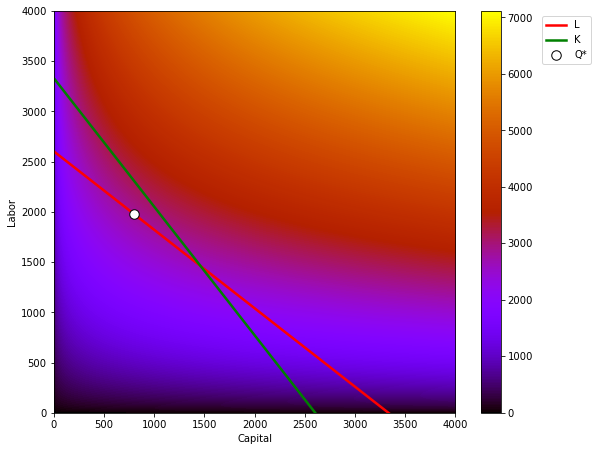

In [21]:
plt.figure(figsize=(9,9))

plt.imshow(Q, cmap='gnuplot')
plt.plot(labor_constraint(np.linspace(0,4000,4000)), 'r-', linewidth=2.5, label='L')
plt.plot(capital_constraint(np.linspace(0,4000,4000)), 'g-', linewidth=2.5, label='K')

plt.plot(*targets[1:], 'w.', label='Q*', mec='k', ms=19)
#plt.plot(*targets[1:], 'w*', label='Q*', mec='k', ms=14)
#plt.plot(data['capital'], data['labor'], 'w.', mec='k', ms=11)

plt.xlim([0,4000])
plt.ylim([0,4000])
plt.xlabel('Capital')
plt.ylabel('Labor')
plt.legend(loc='upper right', bbox_to_anchor=(1.35,1.0))
plt.colorbar(shrink=0.821)

plt.show();

---

#### True solution

In [22]:
true_maximum = ( (beta_1 * bdgt) / rent , (beta_2 * bdgt) / wage )
true_lambda = rent / (bdgt / (rent + rent*beta_2 / beta_1))
print('capital:', true_maximum[0])
print('labor:', true_maximum[1])
print('lambda:', true_lambda)

capital: 794.5949133690174
labor: 1983.389390597122
lambda: 0.0018877543447139912


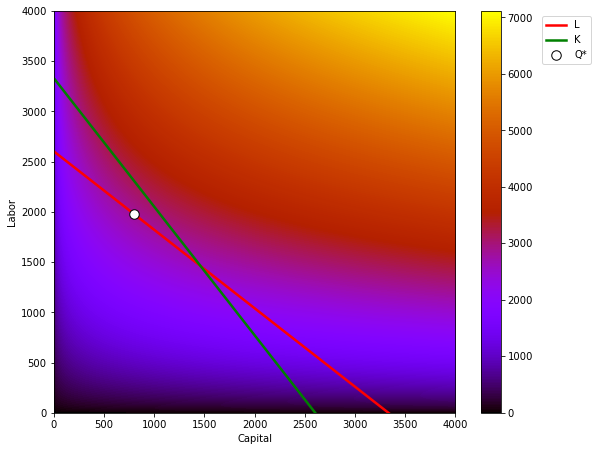

In [23]:
plt.figure(figsize=(9,9))

plt.imshow(Q, cmap='gnuplot')
plt.plot(labor_constraint(np.linspace(0,4000,4000)), 'r-', linewidth=2.5, label='L')
plt.plot(capital_constraint(np.linspace(0,4000,4000)), 'g-', linewidth=2.5, label='K')

plt.plot(*true_maximum, 'w.', label='Q*', mec='k', ms=19)
#plt.plot(*true_maximum, 'w*', label='Q*', mec='k', ms=14)
#plt.plot(data['capital'], data['labor'], 'w.', mec='k', ms=11)

plt.xlim([0,4000])
plt.ylim([0,4000])
plt.xlabel('Capital')
plt.ylabel('Labor')
plt.legend(loc='upper right', bbox_to_anchor=(1.35,1.0))
plt.colorbar(shrink=0.821)

In [24]:
print('Capital:', true_maximum[0])
print('LaborL', true_maximum[1]) 
print('Production:', output(true_maximum[0], true_maximum[1]))

Capital: 794.5949133690174
LaborL 1983.389390597122
Production: 2836.4773097173506


In [25]:
B = bordered_hessian(true_lambda, true_maximum[0], true_maximum[1])
print('',
    np.linalg.det(B[:1,:1]), 
    np.linalg.det(B[:2,:2]), 
    np.linalg.det(B[:3,:3]),
    sep='   |H|: ',
     )

   |H|: 0.0   |H|: -2.25   |H|: 0.005183439515071668


In [26]:
print(gradient(true_lambda, true_maximum[0], true_maximum[1]).flatten())

[0.         0.84811156 1.0855828 ]
